In [24]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
import qiskit
import qiskit_machine_learning
print(qiskit.version.get_version_info())
print(qiskit_machine_learning.version.get_version_info())

1.2.4
0.8.0


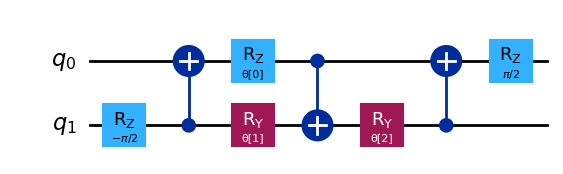

In [25]:
# We now define a two qubit unitary as defined in [3]

def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl")

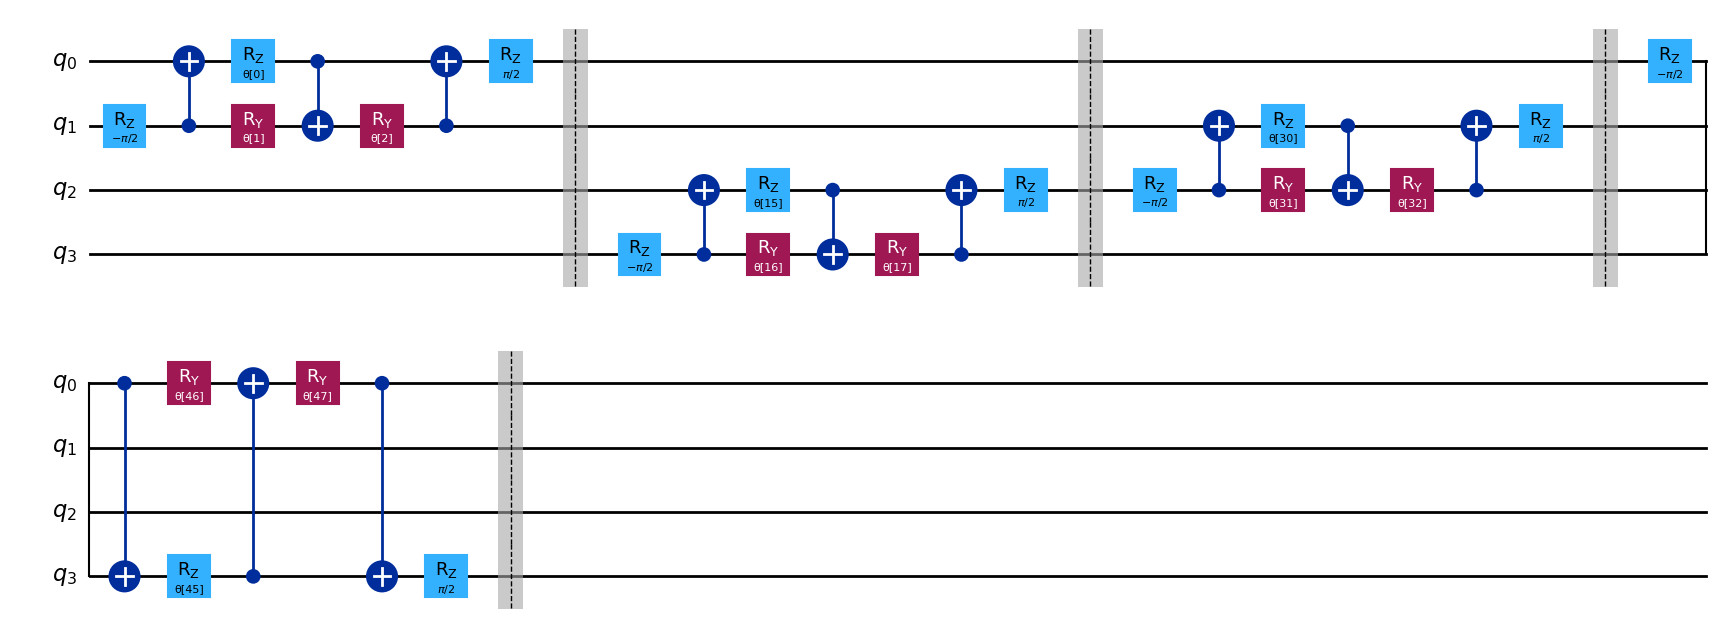

In [26]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 15)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 15)]), [q1, q2])
        qc.barrier()
        param_index += 15
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 15)]), [q1, q2])
        qc.barrier()
        param_index += 15

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl")

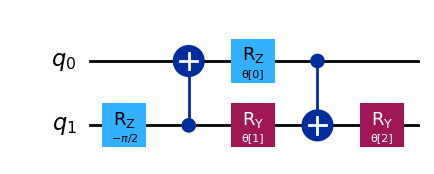

In [27]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target

params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl")

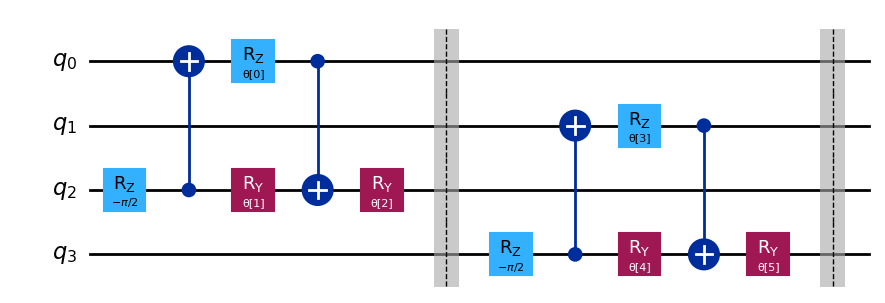

In [28]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")

In [29]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/(255.0/np.pi), x_test[..., np.newaxis]/(255.0/np.pi)
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [30]:
a = 3
b = 4
def filter_abcd(x, y):
    keep = (y == a) | (y == b)
    x, y = x[keep], y[keep]
    return x,y

In [31]:
x_train, y_train = filter_abcd(x_train, y_train)
x_test, y_test = filter_abcd(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 11973
Number of filtered test examples: 1992


4


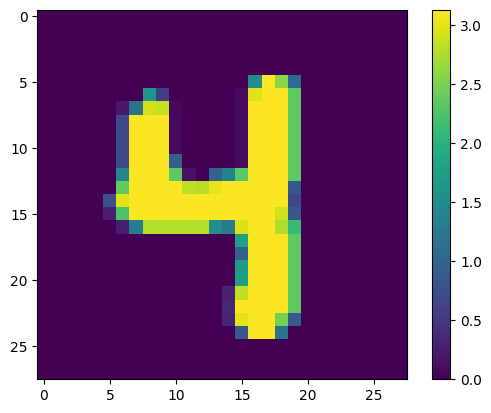

In [32]:
img = 13
print(y_train[img])
plt.imshow(x_train[img, :, :, 0])
plt.colorbar()

In [33]:
x_train_small = tf.image.resize(x_train, (4,4), method = 'area').numpy()
x_test_small = tf.image.resize(x_test, (4,4), method = 'area').numpy()

4


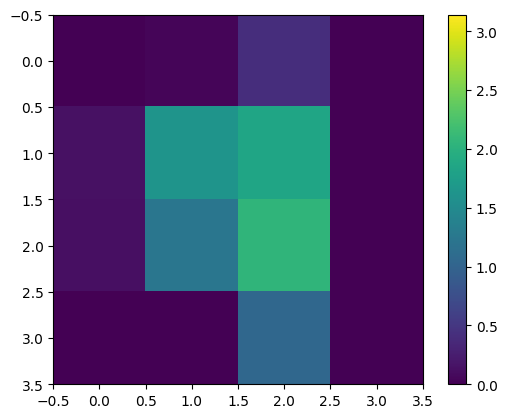

In [34]:
img = 13
print(y_train[img])
plt.imshow(x_train_small[img,:,:,0], vmin=0, vmax=np.pi)
plt.colorbar()

In [35]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)
   
    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass


    num_uniq_a = sum(1 for value in mapping.values() if len(value) == 1 and a in value)
    num_uniq_b = sum(1 for value in mapping.values() if len(value) == 1 and b in value)
    num_uniq_all = sum(1 for value in mapping.values() if len(value) >= 2)


    print("Number of unique images:", len(mapping.values()))
    print("Number of unique ", a, "'s: ", num_uniq_a)
    print("Number of unique ", b, "'s: ", num_uniq_b)
    print("Number of unique contradicting labels: ", num_uniq_all)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))
   
    return np.asarray(new_x), np.asarray(new_y)

In [36]:
import collections
resized_train_images, train_labels = remove_contradicting(x_train_small, y_train)
resized_test_images, test_labels = remove_contradicting(x_test_small, y_test)

Number of unique images: 11973
Number of unique  3 's:  6131
Number of unique  4 's:  5842
Number of unique contradicting labels:  0

Initial number of images:  11973
Remaining non-contradicting unique images:  11973
Number of unique images: 1992
Number of unique  3 's:  1010
Number of unique  4 's:  982
Number of unique contradicting labels:  0

Initial number of images:  1992
Remaining non-contradicting unique images:  1992


In [37]:
# Reformatting Data
y_int = []
for x in train_labels:
    if x == a:
        y_int.append(1)
    else: 
        y_int.append(-1)
        
y1_int = []
for x in test_labels:
    if x == a:
        y1_int.append(1)
    else: 
        y1_int.append(-1)

x_reshaped = []
x1_reshaped = []


for b in resized_train_images:
    x_reshaped.append(b.reshape(1,16))
for b in resized_test_images:
    x1_reshaped.append(b.reshape(1,16))
    
## Convert [[[16 values]]] to [[16 values]]
final_x = []
final_x1 = []
for entry in x_reshaped:
    final_x.append(entry[0])
for entry in x1_reshaped:
    final_x1.append(entry[0])

x = np.asarray(final_x)
y = np.asarray(y_int)
x1 = np.asarray(final_x1)
y1 = np.asarray(y1_int)

# Limiting training dataset to lower training time.
x = x[0:1000]
y = y[0:1000]
x1 = x1[0:1000]
y1 = y1[0:1000]

print(x)
print(y)

[[0.0359542  0.         0.04701703 ... 0.         0.54685587 0.        ]
 [0.         0.26902792 0.86968946 ... 1.3765682  0.4684103  0.        ]
 [0.         0.         0.0341942  ... 0.43195325 0.         0.        ]
 ...
 [0.2599765  0.23609087 0.72788393 ... 0.         0.72712976 0.05204559]
 [0.02086852 0.22427376 0.49481025 ... 0.         0.77917534 0.        ]
 [0.         0.8033124  0.03394278 ... 0.36306196 0.6207757  0.        ]]
[-1  1 -1  1  1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1 -1 -1  1  1  1
 -1 -1  1 -1  1  1 -1 -1  1 -1  1 -1 -1 -1  1  1 -1  1  1  1  1 -1 -1  1
  1 -1  1  1  1  1 -1 -1 -1 -1  1  1 -1  1 -1 -1 -1  1 -1  1  1 -1  1 -1
 -1  1 -1 -1  1  1 -1 -1 -1 -1 -1 -1  1 -1  1 -1 -1 -1  1  1 -1 -1  1  1
 -1  1 -1  1  1  1  1  1 -1  1 -1  1  1  1  1 -1 -1  1 -1  1 -1 -1 -1 -1
  1 -1  1  1  1 -1 -1  1 -1 -1  1  1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1
  1 -1 -1 -1  1 -1  1  1  1 -1 -1  1  1 -1 -1  1 -1  1 -1 -1 -1 -1 -1  1
  1  1  1  1  1 -1  1 -1  1 -1  1 -1 -1 -1  1

In [38]:
# Helper Functions to fix up data
def count(y):
    counta = 0
    countb = 0
    for i in range(len(y)):
        if y[i] == 1:
            counta+=1
        elif y[i] == -1:
            countb+=1
    return(counta, countb)

def balance_lists(x, y, max_count=452):
    """Balances two lists x and y based on the values in y (0 or 1)."""
    
    x_balanced = []
    y_balanced = []
    count0 = 0
    count1 = 0

    for i in range(len(y)):
        if y[i] == 1:
            if count0 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count0 += 1
        elif y[i] == -1:
            if count1 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count1 += 1

    return x_balanced, y_balanced

def shuffle(arr1, arr2):
    assert len(arr1) == len(arr2)
    p = np.random.permutation(len(arr1))
    return arr1[p], arr2[p]

In [39]:
# Further Data Cleaning Using Helper Functions
print("original:", count(y))

x,y = balance_lists(x, y)

print("balanced:", count(y))

# Converting to nparray
x = np.asarray(x)
y = np.asarray(y)
x1 = np.asarray(x1)
y1 = np.asarray(y1)
objective_func_vals = []

x,y = shuffle(x,y)
print("shuffled:", count(y))

print("final:", x)
print(y)

original: (477, 523)
balanced: (452, 452)
shuffled: (452, 452)
final: [[0.         0.         0.         ... 0.4897817  0.16317676 0.        ]
 [0.         0.16041106 0.38518766 ... 0.48148462 0.         0.        ]
 [0.         0.07215983 0.71003264 ... 0.8224209  0.0359542  0.        ]
 ...
 [0.         0.11842258 0.35099348 ... 0.9908777  0.7437239  0.        ]
 [0.         0.04626275 0.17348531 ... 0.         0.764844   0.        ]
 [0.         0.         0.30649072 ... 0.35627344 0.         0.        ]]
[-1  1  1  1 -1  1  1  1  1 -1  1 -1 -1  1 -1  1  1  1  1 -1  1  1 -1 -1
 -1 -1 -1 -1  1  1  1  1  1  1  1  1 -1  1  1  1 -1 -1  1 -1  1  1 -1  1
  1  1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1  1  1  1 -1 -1  1 -1  1  1  1 -1
  1 -1 -1 -1 -1 -1 -1  1 -1  1 -1 -1  1 -1 -1 -1  1  1  1  1 -1 -1 -1 -1
 -1 -1 -1 -1 -1  1 -1  1  1  1  1  1  1 -1 -1  1 -1  1 -1 -1  1  1 -1 -1
 -1  1  1 -1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1 -1 -1  1
  1 -1  1  1  1  1  1  1  1 -1  1 -1 -1  1 -1 -1

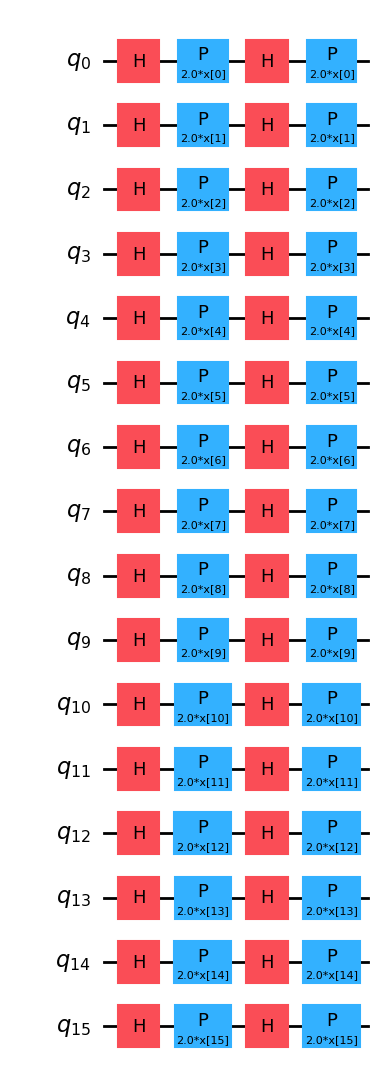

In [40]:
# Feature Map Instantiation
feature_map = ZFeatureMap(16)
feature_map.decompose().draw("mpl")

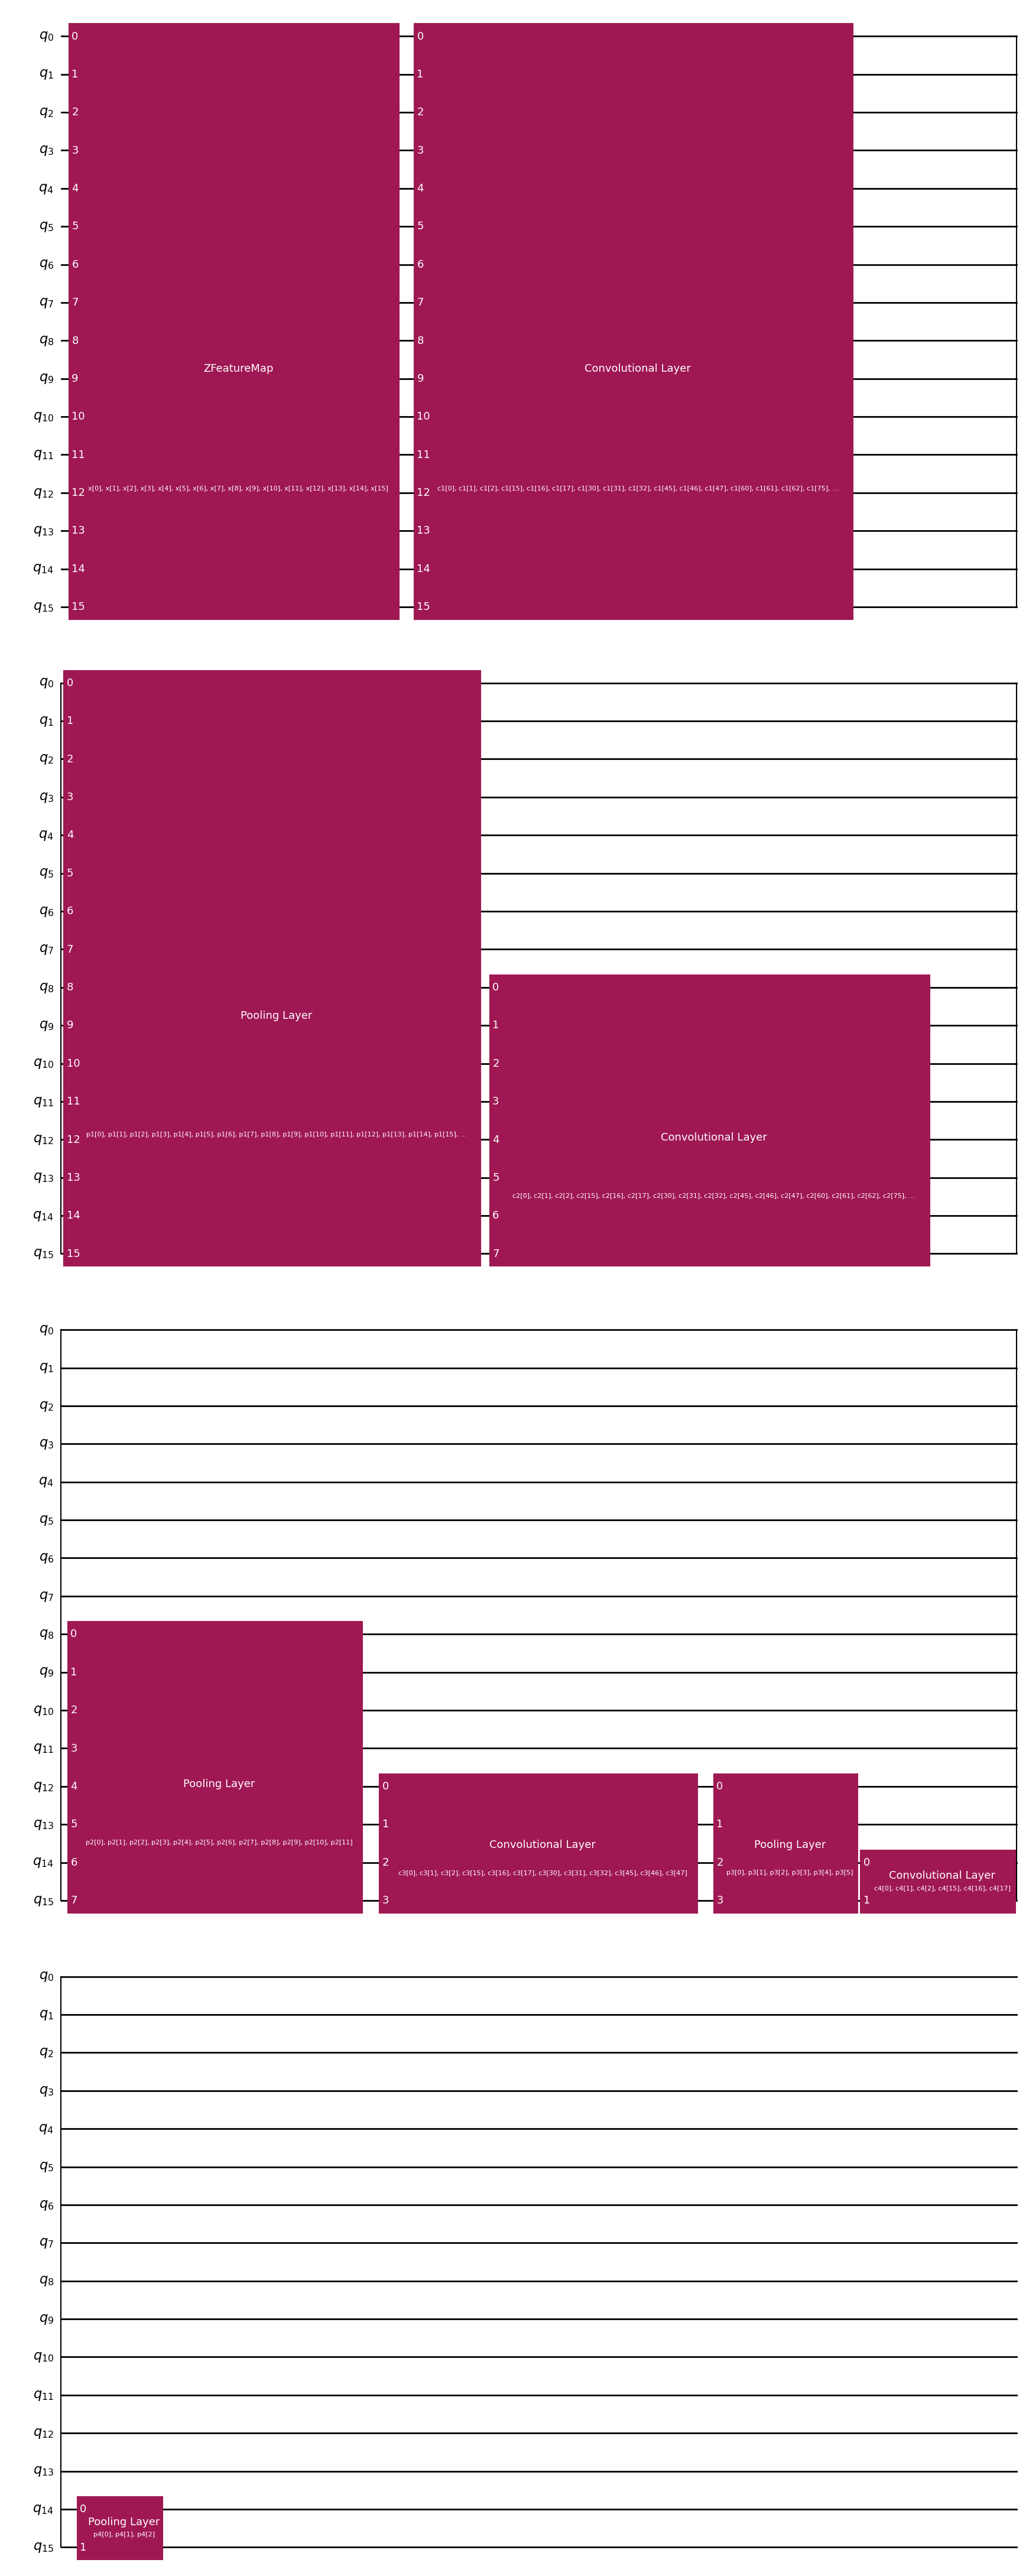

In [41]:
# Ansatz Instantiation
ansatz = QuantumCircuit(16, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(16, "с1"), list(range(16)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14, 15], "p1"), list(range(16)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(8, "c2"), list(range(8, 16)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p2"), list(range(8, 16)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(4, "c3"), list(range(12, 16)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p3"), list(range(12, 16)), inplace=True)

# Fourth Convolutional Layer
ansatz.compose(conv_layer(2, "c4"), list(range(14, 16)), inplace=True)

# Fourth Pooling Layer
ansatz.compose(pool_layer([0], [1], "p4"), list(range(14, 16)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(16)
circuit.compose(feature_map, range(16), inplace=True)
circuit.compose(ansatz, range(16), inplace=True)
display(circuit.draw("mpl"))

In [42]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    print("objective function value", objective_func_vals)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [43]:
# Check GPU Availability
from qiskit_aer import AerSimulator
print(AerSimulator().available_devices())
print(AerSimulator().available_methods())

('CPU', 'GPU')
('automatic', 'statevector', 'density_matrix', 'stabilizer', 'matrix_product_state', 'extended_stabilizer', 'unitary', 'superop', 'tensor_network')


In [44]:
# Setup EstimatorQNN with GPU/Statevector Configuration
from qiskit_aer.primitives import Estimator

estimator = Estimator()
estimator.set_options(device='GPU')
estimator.set_options(method="statevector")

observable = SparsePauliOp.from_list([("Z" + "I" * 15, 1)])

qnn = EstimatorQNN(
    estimator = estimator,
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

/tmp/ipykernel_41468/2963654934.py:10: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(
/tmp/ipykernel_41468/2963654934.py:10: UserWarning: No number of qubits was not specified (None) and was retrieved from `circuit` (16). If `circuit` is transpiled, this may cause unstable behaviour.
  qnn = EstimatorQNN(


In [45]:
# Classifier to forward and backward pass data (default loss = squared_error)
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=100),
    callback=callback_graph,
    warm_start=True,
)

objective function value [1.046427258348043, 1.0457145387092524, 1.0400258840712826, 1.0279362096195728, 1.0299162273913358, 1.04640326457741, 1.0563441504419377, 1.02645780343925, 0.9895107345243471, 1.0446958415276182, 0.9905801367970695, 0.9743965621543141, 0.9975309540740157, 0.9732005743853813, 0.9829323523867447, 0.9953715358160239, 0.979345123324774, 0.9734913311173431, 0.9765199644375692, 0.9762399850693424, 0.9803590479150283, 0.9787366875505026, 0.9782713451216706, 0.97746921218602, 0.960743465254792, 0.964929445654945, 0.9843250882309095, 0.9686834875461274, 0.9620473954529889, 1.0062613951421417, 0.9735673634351882, 0.9735589575978507, 0.9757805714565041, 0.9586904702988346, 0.9704937766083573, 0.9636430824752402, 0.9669403607866406, 0.957212270888607, 0.962391836453328, 0.9843243413266882, 0.9575283717265172, 0.9651122979358234, 0.9898869168441907, 0.953142415105769, 0.9527864751562608, 0.9459499933023369, 0.9492021661944094, 0.9701555977880427, 0.9643500631889411, 0.94678

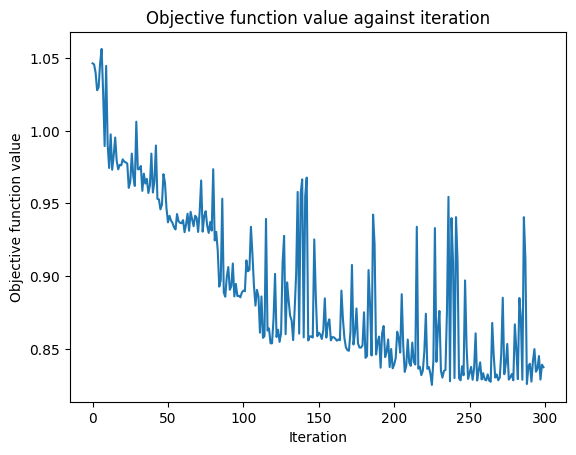

[array([1.54962013e+00, 1.82940305e+00, 1.21251146e+00, 7.84700025e-01,
       6.57248261e-01, 1.61115303e-01, 1.42000300e+00, 1.74592951e+00,
       5.33397182e-02, 7.35846197e-01, 1.88707480e+00, 1.88715595e-01,
       1.17167784e+00, 4.41993186e-02, 6.53688569e-01, 3.75778095e-02,
       9.69992926e-01, 3.29493963e-01, 6.13860559e-01, 6.63800175e-01,
       9.58490919e-01, 7.06122206e-01, 5.56265705e-01, 1.93713012e+00,
       4.14923031e-01, 2.98290495e-01, 5.37880549e-01, 6.95405085e-04,
       1.56150798e-01, 5.55269241e-01, 7.33093350e-01, 1.17254589e-03,
       1.25197683e+00, 2.69342381e-01, 5.33257424e-01, 8.49954610e-01,
       1.11290945e+00, 9.47880256e-01, 7.26655147e-01, 9.99793459e-01,
       2.09254581e-01, 1.81773320e-01, 1.88759275e+00, 1.26123677e+00,
       1.14055983e+00, 5.00698753e-01, 8.50657265e-01, 3.94419692e-02,
       4.53008533e-01, 1.15162291e+00, 2.24968334e-01, 4.74577273e-01,
       1.11822203e+00, 1.45006728e+00, 1.69082145e+00, 1.92850087e-01,
     

In [46]:
# Checkpoint Arrays
cpt_weights = []
cpt_train = []
cpt_test = []

for i in range(3):
    # Shuffling
    shuffle(x,y)
    print(x,y)

    # Run Fit
    classifier.fit(x, y)

    # Checking checkpoint data for overfitting/underfitting signs
    cpt_weights.append(classifier.weights)
    cpt_train.append(f"{np.round(100 * classifier.score(x, y), 2)}%")
    cpt_test.append(f"{np.round(100 * classifier.score(x1, y1), 2)}%")

    # Logs to monitor performance
    print(cpt_weights, cpt_train, cpt_test)

# Saving predicted values for test data to display later
y_predict = classifier.predict(x1)

In [47]:
#101m 20.7s Runtime
print(cpt_weights, cpt_train, cpt_test)

[array([1.54962013e+00, 1.82940305e+00, 1.21251146e+00, 7.84700025e-01,
       6.57248261e-01, 1.61115303e-01, 1.42000300e+00, 1.74592951e+00,
       5.33397182e-02, 7.35846197e-01, 1.88707480e+00, 1.88715595e-01,
       1.17167784e+00, 4.41993186e-02, 6.53688569e-01, 3.75778095e-02,
       9.69992926e-01, 3.29493963e-01, 6.13860559e-01, 6.63800175e-01,
       9.58490919e-01, 7.06122206e-01, 5.56265705e-01, 1.93713012e+00,
       4.14923031e-01, 2.98290495e-01, 5.37880549e-01, 6.95405085e-04,
       1.56150798e-01, 5.55269241e-01, 7.33093350e-01, 1.17254589e-03,
       1.25197683e+00, 2.69342381e-01, 5.33257424e-01, 8.49954610e-01,
       1.11290945e+00, 9.47880256e-01, 7.26655147e-01, 9.99793459e-01,
       2.09254581e-01, 1.81773320e-01, 1.88759275e+00, 1.26123677e+00,
       1.14055983e+00, 5.00698753e-01, 8.50657265e-01, 3.94419692e-02,
       4.53008533e-01, 1.15162291e+00, 2.24968334e-01, 4.74577273e-01,
       1.11822203e+00, 1.45006728e+00, 1.69082145e+00, 1.92850087e-01,
     

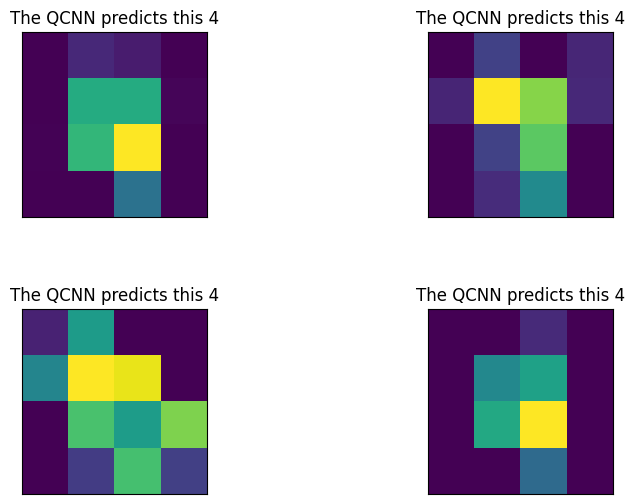

In [48]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(x1[i].reshape(4, 4), aspect="equal")
    if y_predict[i] == 1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 3")
    if y_predict[i] == -1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this 4")
plt.subplots_adjust(wspace=0.1, hspace=0.5)

In [49]:
# Printing Actual Data
y1[:1000]

array([-1, -1,  1, -1, -1, -1,  1,  1, -1, -1,  1, -1, -1,  1, -1,  1, -1,
       -1,  1,  1, -1,  1,  1,  1, -1, -1, -1,  1, -1, -1, -1, -1, -1,  1,
        1, -1, -1, -1, -1, -1, -1,  1,  1, -1,  1,  1, -1,  1,  1, -1,  1,
        1, -1,  1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1, -1,  1, -1, -1,  1,  1, -1, -1,  1, -1,  1, -1,
       -1, -1, -1,  1,  1, -1,  1,  1,  1,  1,  1, -1, -1,  1, -1,  1,  1,
        1, -1,  1, -1,  1,  1,  1,  1, -1, -1, -1, -1, -1,  1, -1, -1, -1,
        1, -1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1, -1,  1,  1,  1,  1,
       -1, -1,  1, -1,  1,  1,  1,  1, -1, -1,  1, -1, -1, -1, -1, -1,  1,
        1, -1, -1,  1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1,  1,  1, -1,
       -1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1, -1, -1, -1, -1,  1,  1,
        1,  1, -1,  1,  1,  1,  1, -1, -1, -1, -1,  1, -1,  1,  1,  1, -1,
        1,  1,  1, -1,  1,  1, -1, -1, -1, -1,  1,  1,  1, -1, -1,  1, -1,
       -1,  1,  1, -1, -1

In [50]:
# Printing Predicted Data for Comparision
y_predict[:1000]

array([[-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
      

In [51]:
# Printing Weights for Backup Checkpoint
classifier.weights

array([2.54962013e+00, 1.82940305e+00, 1.21251146e+00, 7.84700025e-01,
       6.57248261e-01, 1.61115303e-01, 2.42000300e+00, 2.74592951e+00,
       5.33397182e-02, 7.35846197e-01, 2.88707480e+00, 1.88715595e-01,
       2.17167784e+00, 4.41993186e-02, 6.53688569e-01, 3.75778095e-02,
       9.69992926e-01, 2.32949396e+00, 6.13860559e-01, 6.63800175e-01,
       9.58490919e-01, 7.06122206e-01, 5.56265705e-01, 1.93713012e+00,
       1.41492303e+00, 2.98290495e-01, 5.37880549e-01, 6.95405085e-04,
       1.56150798e-01, 5.55269241e-01, 7.33093350e-01, 1.17254589e-03,
       1.25197683e+00, 2.69342381e-01, 5.33257424e-01, 8.49954610e-01,
       1.11290945e+00, 9.47880256e-01, 7.26655147e-01, 9.99793459e-01,
       2.09254581e-01, 1.81773320e-01, 1.88759275e+00, 1.26123677e+00,
       1.14055983e+00, 5.00698753e-01, 8.50657265e-01, 3.94419692e-02,
       4.53008533e-01, 1.15162291e+00, 2.24968334e-01, 4.74577273e-01,
       1.11822203e+00, 1.45006728e+00, 1.69082145e+00, 1.92850087e-01,
      

In [53]:
# Saving Model
classifier.save("Estimator2ClassCircuit1")